# Example: simulating observations of Gaia stars with G-band magnitude < 7.0

In [1]:
import sys
sys.path.append('../')
from STLib.sensor import Sensor
from STLib.lens import Lens
from STLib.camera import Camera
from STLib.functions.psf import airyPSFModel, defocusPSFModel, pillboxPSFModel, gaussianPSFModel
from STLib.functions.dark import exponentialDarkModel
import STLib.utils

STLib.utils.ENABLE_TIMER = True

import numpy as np
np.random.seed(1)  # reproducibility
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib widget
from astropy import units
from astropy.table import Table

## Construct Camera Model

### Lens

Define the aperture, focal length, and point spread function (PSF).

There are several built-in PSF models:

- Airy disk (diffraction limited PSF): 
  - The intensity is given by: $I(x,y) = I_0\left[\dfrac{2J_1[\nu]}{\nu}\right]^2$, where $\nu = \dfrac{\pi D \cdot \sqrt{x^2+y^2}}{\lambda \cdot \sqrt{x^2+y^2+f^2}}$.
  - We care about flux (or power), which is $\displaystyle \int\int I(x,y) \;dxdy \cdot \dfrac{\pi \cdot (D/2)^2}{(\lambda f)^2}$.
  - $I_0$ is the maximum intensity, $J_1$ is the 1st order Bessel function of the first kind.
  - $x, y$ are the sample coordinates on the detector plane with the optical axis as $(0, 0)$, 
  - $f$ is the focal length, $D$ is the aperture diameter, and $\lambda$ is the wavelength of the source.
- Defocused PSF:
  - Defined in Eq. 40 of [Basic Wavefront Aberration Theory for Optical Metrology](https://wp.optics.arizona.edu/jcwyant/wp-content/uploads/sites/13/2016/08/03-BasicAberrations_and_Optical_Testing.pdf) by Wyant and Creath.
  - Additional credit goes to [this blog](https://www.strollswithmydog.com/a-simple-model-for-sharpness-in-digital-cameras-defocus/).
  - The power is given by: $\dfrac{P_\text{tot}\pi}{\lambda\cdot(f/D)}\cdot \displaystyle \left\lvert\int_0^1 e^{i \frac{2\pi}{\lambda} W_{020} \rho^2} \cdot J_0\bigg[\dfrac{\pi r}{\lambda\cdot(f/D)} \rho \bigg] \cdot \rho \;d\rho\right\rvert^2$.
  - $P$ is the total power, $J_0$ is the 0th order Bessel function of the first kind;
  - $W_{020}$ is the peak optical path difference (the term that controls defocus).
- Gaussian PSF:
  - The power is given by a 2D Gaussian distribution with mean $\mathbf{0}$ and covariance $\mathbf{\Sigma}$.
- Pillbox PSF:
  - The power is given by $P(x,y) = \begin{cases} P_\text{tot} / (\pi R^2) & \text{, } x^2+y^2 < R^2 \\ 0 & \text{, otherwise} \end{cases}$
  - This generates a flat PSF within a circle of radius $R$.

Custom PSF equations can be defined with the following format:
```python
    def customPSF(x: Number, y: Number) -> float:
```
where the input args will be (x, y) coordinates in `astropy.units.micron`. Verify that the integral of the output approaches unity. Note that the custom PSF will be dynamically type-checked, so type hints are necessary (`Number = typing.Union[int, float]`).

In [2]:
aperture = 50 * units.mm
focal_length = 30 * units.mm
wavelength = 550 * units.nm  # note: nanometers!

# the `psf` returned by <name>PSFModel is a function.
# psf = airyPSFModel(wavelength=wavelength, aperture=aperture, focal_length=aperture)
# psf = defocusPSFModel(wavelength=wavelength, aperture=aperture, focal_length=focal_length, defocus=1.0*wavelength)
# psf = pillboxPSFModel(radius=6*units.micron)
psf = gaussianPSFModel(sigma=10*units.micron)

The lens is defined by the aperture, focal length, transmission efficiency, PSF, and lens distortion. 

Here, aperture and focal length are assumed to be in units of mm and must be passed without units (fix in a future commit?). 

The Brown-Conrady lens distortion model (see [here](https://docs.nvidia.com/vpi/algo_ldc.html) and [here](https://en.wikipedia.org/wiki/Distortion_(optics)#Software_correction)) is defined by radial terms `k1`-`k6` and tangential terms `p1`, `p2`.

For computational reasons, the PSF model will only be computed within the nearest rectangular grid of pixels relative to the center of the ray. The half-width/height of this grid is defined via the argument `psf_bounds` as a tuple.

In [3]:
lens = Lens(aperture=aperture.to(units.mm).value, focal_length=focal_length.to(units.mm).value, 
            transmission_efficiency=0.99, 
            k1=0.4, k2=0.1, k4=0.1,
            p1=0.01,
            psf=psf, psf_bounds=(3,3))

### Sensor

Define the dark current model. Currently, the only built-in dark current model is an exponential model. 

You can add your own model which should adhere to the following format:
```python
    customDark(T: Number) -> float:
```
The function should return `astropy.units.pA / astropy.units.cm**2`.

In [4]:
darkFunc = exponentialDarkModel(I0 = 0.5, T0 = 20, dT = 10)

Define the sensor with the following parameters:
- `width_px`/`height_px`: number of pixels in width/height.
- `px_len`: size of pixel in microns. If scalar, the pixel is assumed to be square. Rectangular pixels can be defined with a tuple specifying `(width, height)`.
- `px_pitch`: spacing between pixels in microns. Can be scalar or tuple similar to `px_len`.
- `band`: select from a set of pre-defined filter bandpasses. Currently includes `[U,B,V,R,I,J,H,K,u,g,r,i,z]`. This defines the effective wavelength, bandpass, and reference flux. 
- `filter_efficiency`: average filter efficiency in range $[0,1]$.
- `quantum_efficiency`: average filter QE in range $[0,1]$.
- `dark_current`: dark current function as discussed above.
- `hot_pixels`: 2D array of scalars which scale the output of `dark_current`. Use `hot_pixels=None` for no hot pixels, which is equivalent to `hot_pixels=np.ones((height_px,width_px))`.
- `gain`: electron to ADU conversion factor.
- `bias`: scalar, 1D array, or 2D array. Represents a voltage bias in the readout process to prevent negative readings. If scalar, assumes uniform bias. If 1D array, assumes bias is column-dependent. If 2D array, assumes bias is given per pixel. Assumes units of `astropy.units.adu`.
- `full_well_capacity`: charge capacity in units of `astropy.units.electron`.
- `adc_limit`: limit of the ADC counter, typically an even power of 2.
- `bloom`: subset of `{'+x','-x','+y','-y'}`, indicates which direction(s) electrons can leak into if a pixel is saturated. 
- `readout_time`: (planned feature) time needed to read out an image row by row.
- `read_noise`: mean read noise in units of `astropy.units.electron`.

In [5]:
NUM_ROWS = 600
NUM_COLS = 400

BIAS = np.ones(NUM_COLS) * 20
bad_bias_rate = 0.005
bad_cols = np.random.choice(np.arange(NUM_COLS, dtype=int), int(np.ceil(bad_bias_rate * NUM_COLS)), replace=False)
BIAS[bad_cols] = 500

HOT_PX = np.ones((NUM_ROWS, NUM_COLS))
hot_rate = 0.001
bad_px = np.random.choice(np.arange(NUM_COLS*NUM_ROWS, dtype=int), int(np.ceil(hot_rate * NUM_COLS*NUM_ROWS)), replace=False)
HOT_PX.ravel()[bad_px] = np.random.rand(len(bad_px)) * 10 + 5

sensor = Sensor(width_px=NUM_COLS, height_px=NUM_ROWS, 
                px_len=6, px_pitch=6.5, 
                filter_efficiency=0.9, band='g', 
                quantum_efficiency=0.3, dark_current=darkFunc, hot_pixels=HOT_PX,
                gain=5, bias=BIAS, full_well_capacity=1e6, adc_limit=2**14,
                bloom={'+y'}, 
                readout_time=0, read_noise=25)

### Camera

The camera is simply defined by the lens and sensor, along with its orientation in some frame of reference (planned: rigorous reference frame definitions) given as right ascension, declination, and roll.

In [6]:
camera = Camera(lens=lens, sensor=sensor, ra=0, dec=0, roll=0)

## Lens Distortion Visualization

We can visualize the lens distortion as follows:

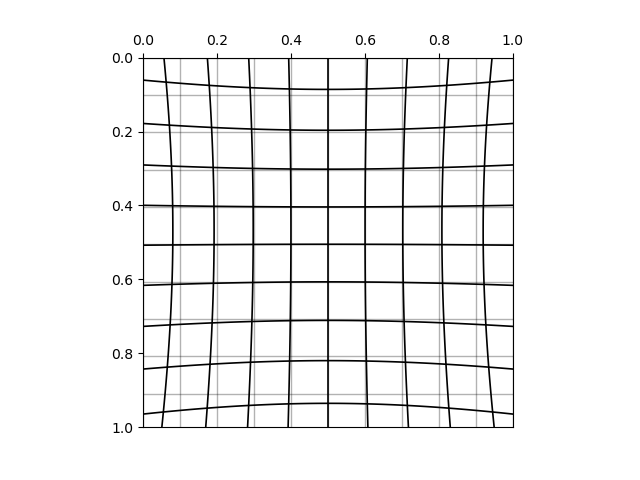

In [7]:
num_rows = 100
num_cols = 101
col_step = 10
row_step = 10
_x = np.linspace(0,1,num_cols)
_y = np.linspace(0,1,num_rows)
X,Y = np.meshgrid(_x,_y)
Xd, Yd = camera.lens.applyDistortion(X,Y)

fig, ax = plt.subplots()

# reference grid
for col in range(0, num_cols, col_step):
    ax.plot(X[:,col], Y[:,col], c='k', alpha=0.3, lw=1)
for row in range(0, num_rows, row_step):
    ax.plot(X[row,:], Y[row,:], c='k', alpha=0.3, lw=1)

# distorted grid
for col in range(0, num_cols, col_step):
    ax.plot(Xd[:,col], Yd[:,col], c='k', lw=1.2)
for row in range(0, num_rows, row_step):
    ax.plot(Xd[row,:], Yd[row,:], c='k', lw=1.2)
ax.set_aspect('equal')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.invert_yaxis()
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.show()

## Dark Image

Take an image with no stars to simulate a dark image. Set `sky_mag` really high to avoid simulating background light. 

In [8]:
camera.sensor.clear()
image = camera.snap(sky_mag=100, exposure_time=0.1, temperature=20, 
                    ra=[], 
                    dec=[], 
                    magnitudes=[])

Function '_applyPSF' took 0.000 seconds.


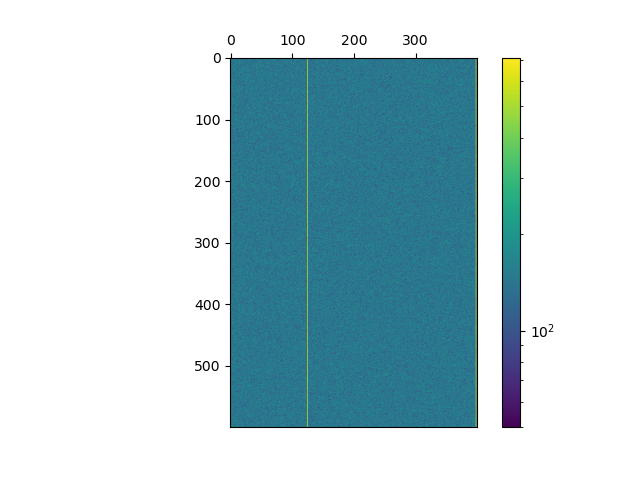

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(image, norm=LogNorm())
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.colorbar(im)
plt.show()

## Gaia Image

### Download Gaia data

In [10]:
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

In [11]:
MAGNITUDE_LIMIT = 8.0
GAIA_PATH = f'../data/gaia_m<{MAGNITUDE_LIMIT}.ecsv'

import os
if not os.path.isfile(GAIA_PATH):

    # Set up the query to fetch stars with g-band magnitude limit
    query = f"""
    SELECT 
        source_id, ref_epoch,
        ra, dec, pmra, pmdec, 
        phot_g_mean_mag, 
        phot_bp_mean_mag, 
        phot_rp_mean_mag
    FROM gaiadr3.gaia_source
    WHERE phot_g_mean_mag < {MAGNITUDE_LIMIT}
    ORDER BY phot_g_mean_mag ASC
    """

    # Run the query asynchronously and dump to file
    job = Gaia.launch_job_async(query, dump_to_file=True, output_format='ecsv', output_file=GAIA_PATH+'.gz')
    os.rename(GAIA_PATH+'.gz', GAIA_PATH)  # already unzipped?

else:

    print("The query results already exist.")

The query results already exist.


### Generate image

In [12]:
catalog = Table.read(GAIA_PATH, format='ascii.ecsv')
catalog = catalog[catalog['phot_g_mean_mag'] < 7]
print(f"Working with {len(catalog)} stars.")

Working with 21329 stars.


In [13]:
camera.sensor.clear()
camera.orient(ra=40, dec=20, roll=45)
image = camera.snap(sky_mag=21.5, exposure_time=1.0, temperature=20, 
                    ra=catalog['ra'].to(units.radian), 
                    dec=catalog['dec'].to(units.radian), 
                    magnitudes=catalog['phot_g_mean_mag'].value)

Function '_applyPSF' took 0.124 seconds.


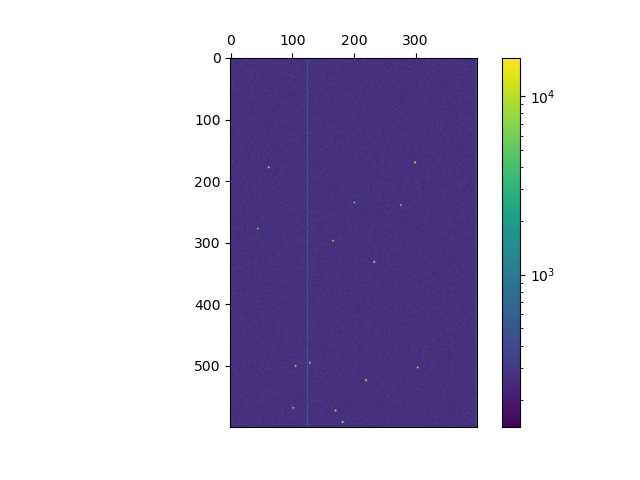

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(image, norm=LogNorm())
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.colorbar(im)
plt.show()

### Export image

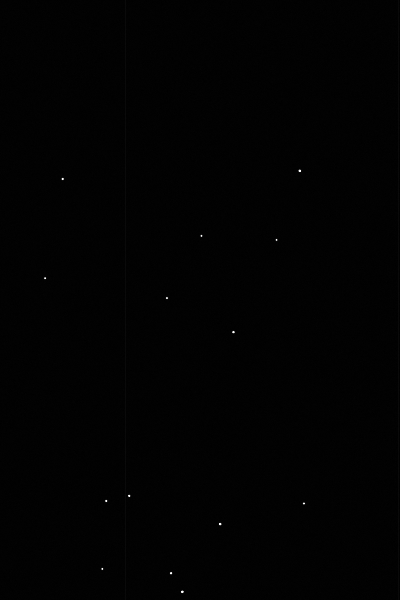

In [15]:
from PIL import Image
image_uint8 = (255 * (image - image.min()) / image.max()).astype(np.uint8)
im = Image.fromarray(image_uint8, mode='L')
display(im)

Try uploading the results to a star identification algorithm (e.g. [astrometry.net](https://nova.astrometry.net/))!

Warning: in practice, one would preprocess the image to reduce the impact of bad columns and hot pixels. If this is not done, star ID might fail. 

In [16]:
im.save('example-images/gaia-test.png')